In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
import time
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import Input
from keras.layers import concatenate
from keras.optimizers import SGD
from keras.layers.core import Lambda
import keras.backend as K
from keras.optimizers import Adam
from keras.constraints import MaxNorm
from keras.models import model_from_json

Using TensorFlow backend.


In [2]:
import seaborn as sns
sns.set()

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"    
import tensorflow as tf

## Hyperparameters choice

In [4]:
LSTM_units = 4
SGD_units = 32

LSTM_units2 = 8
n_g = 8

dropout = 0.2

epoch = 200
batch_size = 200
n_iteration = 2

In [5]:
LSTM_units, SGD_units, LSTM_units2, n_g =     [4,32,8,8]

## Data processing

In [6]:
file = open('a1','rb')
dataset = pickle.load(file, encoding='utf-8')
file.close()

macro_data, micro_data, return_data = dataset
# print(macro_data.shape, micro_data.shape, return_data.shape)
# print(list(map(type, dataset)))

# dataset split
train_micro = micro_data[:2000, :, :]
train_macro = macro_data[:2000, :, :]
train_return = return_data[1:2001, :]
train_micro = (train_micro - train_micro.mean(axis=1).reshape(-1, 1, train_micro.shape[2]))/train_micro.std(axis=1).reshape(-1, 1, train_micro.shape[2])

val_micro = micro_data[2000:2700, :, :]
val_macro = macro_data[2000:2700, :, :]
val_return = return_data[2001:2701, :]
val_micro = (val_micro -val_micro.mean(axis=1).reshape(-1, 1, val_micro.shape[2]))/val_micro.std(axis=1).reshape(-1, 1, val_micro.shape[2])




test_micro = micro_data[2700:-1, :, :]
test_macro = macro_data[2700:-1, :, :]
test_return = return_data[2701:, :]
test_micro = (test_micro - test_micro.mean(axis=1).reshape(-1, 1, test_micro.shape[2]))/\
test_micro.std(axis=1).reshape(-1, 1, test_micro.shape[2])

## model structure
### SGD network

In [7]:
# testing model parameter
ndays = train_micro.shape[0]
nstocks = train_micro.shape[1]
nmacro = train_macro.shape[2]
nmicro = train_micro.shape[2]
LSTM_delay = train_macro.shape[1]

# val model parameter
val_ndays = val_micro.shape[0]


# SGD networks

# data loading
ma1 = Input(shape=(LSTM_delay, nmacro), name='macro')

mi1 = Input(shape=(nstocks,nmicro), name='micro')

ret1 = Input(shape=(nstocks,), name='return')

g_loaded = Input(shape=(nstocks, n_g), name='function_G')

# LSTM
lstm1_1 = LSTM(LSTM_units, name='lstm')(ma1) # (1000, 4)
lstm1 = Lambda(lambda x:K.repeat(x, nstocks), name='lstm_reshape')(lstm1_1)


# SGD weights DNN
w1 = concatenate([mi1, lstm1], name='micro_macro_combined') # (1000, 50, 104)  
w2 = Lambda(lambda x:K.reshape(x, shape=(-1,nstocks*(nmicro+LSTM_units),)), name='ffn_input_reshape')(w1)
w3 = Dense(SGD_units, activation='relu', name='ffn_layer1')(w2)
w4 = Dropout(dropout, name='ffn_dropout1')(w3)
w5 = Dense(SGD_units, activation='relu', name='ffn_layer2')(w4)
w6 = Dropout(dropout, name='ffn_dropout2')(w5)
# w = Dense(50, name='ffn_output_weights',activation='tanh')(w6)
w = Dense(nstocks, name='ffn_output_weights')(w6)


# SGD construction
def construction(x):
    tmp = 1 - x[0] * x[1]
    tmp = K.sum(tmp, axis=1)
    tmp = K.reshape(tmp, shape=(-1,1)) # (1000, 1)
    tmp = K.repeat(tmp, nstocks) # (1000, 50, 1)
    tmp = K.reshape(tmp, shape=(-1,nstocks)) # (1000, 50)
    tmp = tmp * x[1] # (1000, 50)
    tmp = K.reshape(tmp, shape=(-1, nstocks, 1))
    return tmp # the M_{t+1}R_{t+1}

sgd = Lambda(construction, name='sgd')([w,ret1])


# combine those two and calculate loss
loss_function_w1 = Lambda(lambda x:x[0]*x[1], name='loss')([sgd, g_loaded]) 
loss_function_w = Lambda(lambda x:K.reshape(x, shape=(-1, nstocks*n_g)), name='loss_reshape')(loss_function_w1)


def mean_squared_error1(y_true, y_pred):
    return K.mean(K.square(K.mean(y_pred-y_true,axis=0)))
#     return K.mean(K.square(y_pred-y_true))

# with weights output for validation and sgd output for condition network training
model_output_w = Model(inputs=[ma1, mi1], outputs=w) # acquires weights given info
model_output_sgd = Model(inputs=[ma1, mi1, ret1], outputs=sgd) # acquires MR for condition networks

model_output_sgd.compile(optimizer='adam', loss=mean_squared_error1)

# SGD model compile
model_w = Model(inputs=[ma1, mi1, ret1, g_loaded], outputs=loss_function_w)
model_w.compile(optimizer='adam', loss=mean_squared_error1)


### conditional networks

In [8]:
ma2 = Input(shape=(LSTM_delay, nmacro), name='macro')

mi2 = Input(shape=(nstocks,nmicro), name='micro')

sgd_loaded = Input(shape=(nstocks,1), name='sgd')

lstm2_1 = LSTM(LSTM_units2, name='lstm')(ma2) # (1000, 4)
lstm2 = Lambda(lambda x:K.repeat(x, nstocks), name='lstm_reshape')(lstm2_1)

g0 = concatenate([mi2, lstm2], name='g0') # (1000, 50, 104) 
g1 = Lambda(lambda x:K.reshape(x, shape=(-1,nstocks*(nmicro+LSTM_units2),)), name='g1')(g0)
# cons = MaxNorm(max_value=0.001, axis=0)
# g2 = Dense(128, activation='relu',kernel_constraint=cons, bias_constraint=cons, name='g2')(g1)
g3 = Dropout(dropout, name='g3')(g1) # (1000, 50, 8)
g4 = Dense(nstocks*n_g, name='g4')(g3) # (1000, 50, 8)
g5 = Lambda(lambda x:K.reshape(x, shape=(-1,nstocks,n_g)), name='g5')(g4)
g = Lambda(lambda x:(x-K.reshape(K.mean(x, axis=-1), (-1,nstocks,1)))/K.reshape(K.std(x, axis=-1), (-1,nstocks,1)), name='g')(g5)

loss_function_g1 = Lambda(lambda x:x[0]*x[1], name='loss')([sgd_loaded, g]) # (1000,50, 8)
loss_function_g = Lambda(lambda x:K.reshape(x, shape=(-1, nstocks*n_g)), name='loss_reshape')(loss_function_g1)

model_output_g = Model(inputs=[ma2, mi2], outputs=g) # acquires MR for condition networks

def mean_squared_error2(y_true, y_pred):
    return -K.mean(K.square(K.mean(y_pred-y_true,axis=0)))
#     return -K.mean(K.square(y_pred-y_true))

model_g = Model(inputs=[ma2, mi2, sgd_loaded], outputs=loss_function_g)
model_g.compile(optimizer='adam', loss=mean_squared_error2)
# model_g.compile(optimizer='adam', loss='mean_squared_error')

## learning
### loss of training data


done with conditional 0 loss is -0.053113 using 54.88 seconds
done with conditional 1 loss is -0.046595 using 51.03 seconds


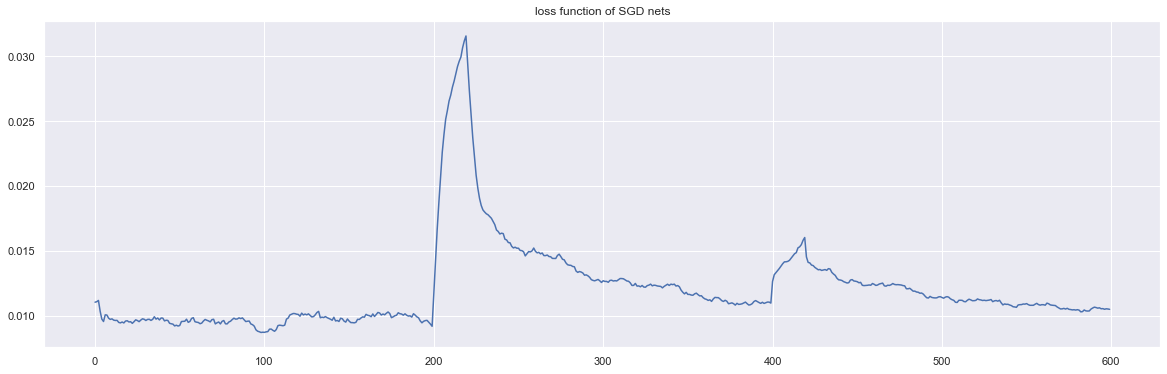

In [9]:
def moving_average(x, n):
    xx = np.cumsum(x)
    xxx = xx.copy()
    xxx[n:] = (xx[n:] - xx[:-n]) / n
    for i in range(n):
        xxx[i] = xxx[i] / (i+1)
    return xxx

# data process
y_train = np.zeros((ndays, n_g*nstocks))
y_train_unconditional = np.zeros((ndays, nstocks, 1))
y_validation = np.zeros((val_ndays, n_g*nstocks))

ma = train_macro
mi = train_micro
ret = train_return
sdf_loss = []
validation_loss=[]


# first use unconditional methods to give a initial guess of sgd
t1 = time.time()
# SDF nets
history_w = model_output_sgd.fit([ma, mi, ret], y_train_unconditional, epochs=epoch, batch_size=batch_size, verbose=0)
function_sgd = model_output_sgd.predict([ma, mi, ret])
sdf_loss = sdf_loss + history_w.history['loss'].copy() # save loss
# print('done with', 0,',train loss is', round(sdf_loss[-1],6) ,', using', round(time.time()-t1, 2), 'seconds')
# plt.plot(moving_average(history_w.history['loss'], 20))
# plt.show()

for i in range(2):
    t1 = time.time()
    # conditional nets
    history_w = model_g.fit([ma, mi, function_sgd], y_train, epochs=epoch,  batch_size=batch_size, verbose=0)
    function_g = model_output_g.predict([ma, mi])
    print('done with conditional', i, 'loss is',round(history_w.history['loss'][-1],6),'using', round(time.time()-t1, 2), 'seconds')
#     plt.plot(moving_average(history_w.history['loss'], 20))
#     plt.show()

    t1 = time.time()
    # SDF nets
    history_w = model_w.fit([ma, mi, ret, function_g], y_train, epochs=epoch, batch_size=batch_size,  verbose=0)
    function_sgd = model_output_sgd.predict([ma, mi, ret])
    sdf_loss = sdf_loss + history_w.history['loss'].copy() # save loss
    validation_loss.append(np.mean((model_w.predict([val_macro, val_micro, val_return, function_g]) - y_validation)**2))
#     print('done with sgd', i,',train loss is', round(sdf_loss[-1],6), ',validation loss is',round(validation_loss,6), ', using', round(time.time()-t1, 2), 'seconds')
#     plt.plot(moving_average(history_w.history['loss'], 20))
#     plt.show()

plt.figure(figsize=(20,6))
plt.plot(moving_average(sdf_loss[:], 20))
plt.title('loss function of SGD nets')
plt.show()


## testing data

E:\anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  
E:\anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: overflow encountered in exp
E:\anaconda3\lib\site-packages\ipykernel_launcher.py:71: RuntimeWarning: overflow encountered in exp


4 32 8 8
                mean       std  shape        SR  bench_mean  bench_std  \
train       0.348959  0.257076   2000  1.357416    0.245355   0.272073   
validation  0.155081  0.277228    700  0.559398    0.127633   0.268468   
test        0.124090  0.217854    532  0.569605    0.007819   0.218102   

            bench_SR  
train       0.901796  
validation  0.475413  
test        0.035849  


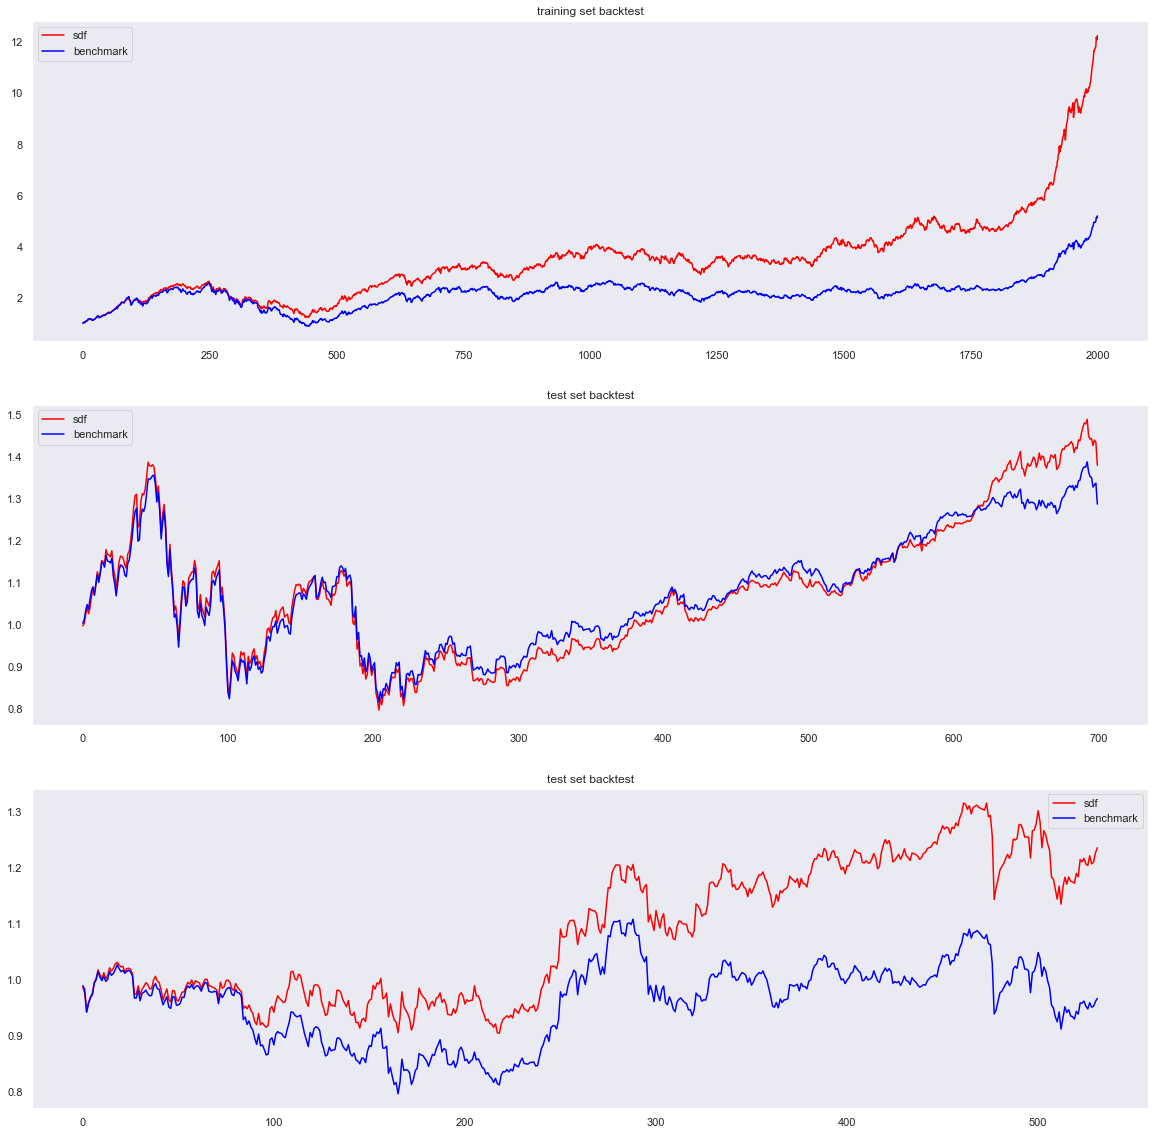

In [124]:
result = pd.DataFrame([[0,0,0,0, 0, 0, 0] for i in range(3)], columns = ['mean','std','shape','SR','bench_mean','bench_std','bench_SR'], index=['train','validation','test'])

# training set condition
train_weights = model_output_w.predict([train_macro[:,:], train_micro[:, :, :]])
# train_weights = (train_weights - train_weights.mean(axis=1).reshape(-1,1)) / train_weights.std(axis=1).reshape(-1,1)
train_weights = 1/(1+np.exp(-train_weights)) 
# train_yield = train_weights
train_daily_return = (train_weights/train_weights.sum(axis=1).reshape(-1,1) * train_return).sum(axis=1)
result.iloc[0, 0] = train_daily_return.mean()*252
result.iloc[0, 1] = train_daily_return.std() * np.sqrt(252)
result.iloc[0, 2] = train_daily_return.shape

fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(311)
benchmark_train = train_return.mean(axis=1)
ax1.plot(np.cumprod(1+train_daily_return), color='red',label='sdf')
ax1.plot(np.cumprod(1+benchmark_train), color='blue',label='benchmark')
plt.legend()
plt.title('training set backtest')
plt.grid()

result.iloc[0, 3] = train_daily_return.mean()/train_daily_return.std()*np.sqrt(252)
result.iloc[0, 4] = benchmark_train.mean()*252
result.iloc[0, 5] = benchmark_train.std()*np.sqrt(252)
result.iloc[0, 6] = benchmark_train.mean()/benchmark_train.std()*np.sqrt(252)





# # val set condition
val_weights = model_output_w.predict([val_macro[:,:], val_micro[:, :, :]])
# test_weights = (test_weights - test_weights.mean(axis=1).reshape(-1,1)) / test_weights.std(axis=1).reshape(-1,1)
val_weights = 1/(1+np.exp(-val_weights))
# train_yield = train_weights
val_daily_return = (val_weights/val_weights.sum(axis=1).reshape(-1,1) * val_return).sum(axis=1)
result.iloc[1, 0] = val_daily_return.mean()*252
result.iloc[1, 1] = val_daily_return.std() * np.sqrt(252)
result.iloc[1, 2] = val_daily_return.shape

benchmark_val = val_return.mean(axis=1)
ax2 = fig.add_subplot(312)
plt.plot(np.cumprod(1+val_daily_return), color='red',label='sdf')
plt.plot(np.cumprod(1+benchmark_val), color='blue',label='benchmark')
plt.legend()
plt.grid()
plt.title('test set backtest')

result.iloc[1, 3] = val_daily_return.mean()/val_daily_return.std()*np.sqrt(252)
result.iloc[1, 4] = benchmark_val.mean()*252
result.iloc[1, 5] = benchmark_val.std()*np.sqrt(252)
result.iloc[1, 6] = benchmark_val.mean()/benchmark_val.std()*np.sqrt(252)















# # training set condition
test_weights = model_output_w.predict([test_macro[:,:], test_micro[:, :, :]])
# test_weights = (test_weights - test_weights.mean(axis=1).reshape(-1,1)) / test_weights.std(axis=1).reshape(-1,1)
test_weights = 1/(1+np.exp(-test_weights))
# train_yield = train_weights
test_daily_return = (test_weights/test_weights.sum(axis=1).reshape(-1,1) * test_return).sum(axis=1)
result.iloc[2, 0] = test_daily_return.mean()*252
result.iloc[2, 1] = test_daily_return.std() * np.sqrt(252)
result.iloc[2, 2] = test_daily_return.shape

benchmark_test = test_return.mean(axis=1)
ax3 = fig.add_subplot(313)
plt.plot(np.cumprod(1+test_daily_return), color='red',label='sdf')
plt.plot(np.cumprod(1+benchmark_test), color='blue',label='benchmark')
plt.legend()
plt.grid()
plt.title('test set backtest')

result.iloc[2, 3] = test_daily_return.mean()/test_daily_return.std()*np.sqrt(252)
result.iloc[2, 4] = benchmark_test.mean()*252
result.iloc[2, 5] = benchmark_test.std()*np.sqrt(252)
result.iloc[2, 6] = benchmark_test.mean()/benchmark.std()*np.sqrt(252)

# plt.show()
print(LSTM_units, SGD_units, LSTM_units2, n_g)
print(result)
print('====================================')

In [125]:
macro_data.shape

(3233, 13, 15)

E:\anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: overflow encountered in exp


4 32 8 8
                mean       std  shape        SR  bench_mean  bench_std  \
train       0.348959  0.257076   2000  1.357416    0.245355   0.272073   
validation  0.155081  0.277228    700  0.559398    0.127633   0.268468   
test        0.124090  0.217854    532  0.569605    0.007819   0.218102   

            bench_SR  
train       0.901796  
validation  0.475413  
test        0.035849  


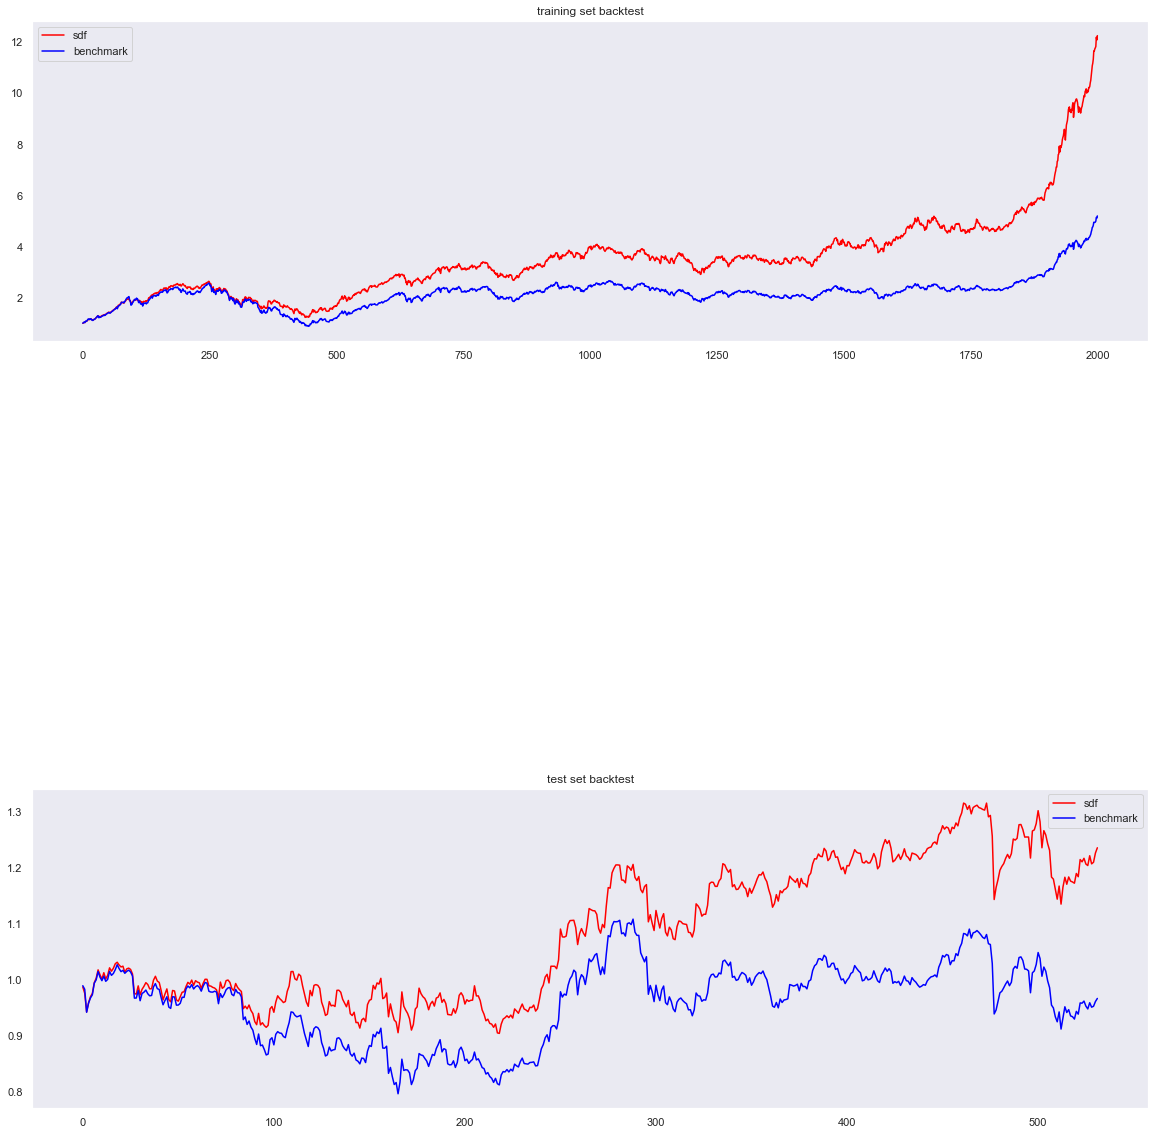

In [126]:
fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(311)
benchmark = train_return.mean(axis=1)
ax1.plot(np.cumprod(1+train_daily_return), color='red',label='sdf')
ax1.plot(np.cumprod(1+benchmark), color='blue',label='benchmark')
plt.legend()
plt.title('training set backtest')
plt.grid()

result.iloc[0, 3] = train_daily_return.mean()/train_daily_return.std()*np.sqrt(252)
result.iloc[0, 4] = benchmark.mean()*252
result.iloc[0, 5] = benchmark.std()*np.sqrt(252)
result.iloc[0, 6] = benchmark.mean()/benchmark.std()*np.sqrt(252)



# # training set condition
test_weights = model_output_w.predict([test_macro[:,:], test_micro[:, :, :]])
# test_weights = (test_weights - test_weights.mean(axis=1).reshape(-1,1)) / test_weights.std(axis=1).reshape(-1,1)
test_weights = 1/(1+np.exp(-test_weights))
# train_yield = train_weights
test_daily_return = (test_weights/test_weights.sum(axis=1).reshape(-1,1) * test_return).sum(axis=1)
result.iloc[2, 0] = test_daily_return.mean()*252
result.iloc[2, 1] = test_daily_return.std() * np.sqrt(252)
result.iloc[2, 2] = test_daily_return.shape

benchmark = test_return.mean(axis=1)
ax2 = fig.add_subplot(313)
plt.plot(np.cumprod(1+test_daily_return), color='red',label='sdf')
plt.plot(np.cumprod(1+benchmark), color='blue',label='benchmark')
plt.legend()
plt.grid()
plt.title('test set backtest')

result.iloc[2, 3] = test_daily_return.mean()/test_daily_return.std()*np.sqrt(252)
result.iloc[2, 4] = benchmark.mean()*252
result.iloc[2, 5] = benchmark.std()*np.sqrt(252)
result.iloc[2, 6] = benchmark.mean()/benchmark.std()*np.sqrt(252)

# plt.show()
print(LSTM_units, SGD_units, LSTM_units2, n_g)
print(result)
print('====================================')

## MV

In [127]:
macro_data, micro_data, return_data = dataset
# print(macro_data.shape, micro_data.shape, return_data.shape)
# print(list(map(type, dataset)))

# dataset split
train_micro = micro_data[:2000, :, :]
train_macro = macro_data[:2000, :, :]
train_return = return_data[1:2001, :]
train_micro = (train_micro - train_micro.mean(axis=1).reshape(-1, 1, train_micro.shape[2]))/train_micro.std(axis=1).reshape(-1, 1, train_micro.shape[2])

val_micro = micro_data[2000:2700, :, :]
val_macro = macro_data[2000:2700, :, :]
val_return = return_data[2001:2701, :]
val_micro = (val_micro -val_micro.mean(axis=1).reshape(-1, 1, val_micro.shape[2]))/val_micro.std(axis=1).reshape(-1, 1, val_micro.shape[2])




test_micro = micro_data[2700:-1, :, :]
test_macro = macro_data[2700:-1, :, :]
test_return = return_data[2701:, :]
test_micro = (test_micro - test_micro.mean(axis=1).reshape(-1, 1, test_micro.shape[2]))/\
test_micro.std(axis=1).reshape(-1, 1, test_micro.shape[2])

In [128]:
import scipy.optimize as sco

In [129]:
C_train=np.cov(train_return.T)
C_val=np.cov(val_return.T)
C_test=np.cov(test_return.T)

In [130]:
train_days=train_return.shape[0]
num=50
def statistics1(weights):
    
    weights=np.array(weights)
    port_return=np.sum(np.dot(train_return,weights))
    
    port_variance = np.dot(weights.T, np.dot(C_train, weights))
    
    port_a=port_return/np.sqrt(port_variance)
    
    
    return [port_return,port_variance,port_a]

def min_variance1(weights):
    
    return -statistics1(weights)[2]

cons = ({'type':'eq', 'fun':lambda x: np.sum(x)-1})
bnds = tuple((0,1) for x in range(num))
train_x = sco.minimize(min_variance1, num*[1./num,], method = 'SLSQP', bounds = bnds)



In [131]:
val_days=val_return.shape[0]
num=50
def statistics2(weights):
    
    weights=np.array(weights)
    port_return=np.sum(np.dot(val_return,weights))
    
    port_variance = np.dot(weights.T, np.dot(C_val, weights))
    
    port_a=port_return/np.sqrt(port_variance)
    
    
    return [port_return,port_variance,port_a]

def min_variance2(weights):
    
    return -statistics2(weights)[2]

cons = ({'type':'eq', 'fun':lambda x: np.sum(x)-1})
bnds = tuple((0,1) for x in range(num))
val_x = sco.minimize(min_variance2, num*[1./num,], method = 'SLSQP', bounds = bnds)


In [132]:
test_days=test_return.shape[0]
num=50
def statistics3(weights):
    
    weights=np.array(weights)
    port_return=np.sum(np.dot(test_return,weights))
    
    port_variance = np.dot(weights.T, np.dot(C_test, weights))
    
    port_a=port_return/np.sqrt(port_variance)
    
    
    return [port_return,port_variance,port_a]

def min_variance3(weights):
    
    return -statistics3(weights)[2]

cons = ({'type':'eq', 'fun':lambda x: np.sum(x)-1})
bnds = tuple((0,1) for x in range(num))
test_x = sco.minimize(min_variance3, num*[1./num,], method = 'SLSQP', bounds = bnds)


In [133]:
mv_train_weights=train_x.x
mv_val_weights=val_x.x
mv_test_weights=test_x.x



mv_train_return = (mv_train_weights/mv_train_weights.sum().reshape(-1,1) * train_return).sum(axis=1)
mv_val_return = (mv_val_weights/mv_val_weights.sum().reshape(-1,1) * val_return).sum(axis=1)
mv_test_return = (mv_test_weights/mv_test_weights.sum().reshape(-1,1) * test_return).sum(axis=1)






In [134]:
result2 = pd.DataFrame([[0,0,0] for i in range(3)], columns = ['Train','Val','Testing'], index=['Benchmark','MV','GAN'])

result2.iloc[2, 0] = train_daily_return.mean()/train_daily_return.std()*np.sqrt(252)
result2.iloc[0, 0] = benchmark_train.mean()/benchmark_train.std()*np.sqrt(252)
result2.iloc[1, 0] = mv_train_return.mean()/mv_train_return.std()*np.sqrt(252)

result2.iloc[2, 1] = val_daily_return.mean()/val_daily_return.std()*np.sqrt(252)
result2.iloc[0, 1] = benchmark_val.mean()/benchmark_val.std()*np.sqrt(252)
result2.iloc[1, 1] = mv_val_return.mean()/mv_val_return.std()*np.sqrt(252)

result2.iloc[2, 2] = test_daily_return.mean()/test_daily_return.std()*np.sqrt(252)
result2.iloc[0, 2] = benchmark_test.mean()/benchmark_test.std()*np.sqrt(252)
result2.iloc[1, 2] = mv_test_return.mean()/mv_test_return.std()*np.sqrt(252)


In [135]:
result2

,Train,Val,Testing
Benchmark,0.901796,0.475413,0.035849
MV,1.554063,1.764187,1.840494
GAN,1.357416,0.559398,0.569605
